# Extracting Respiration Signals with Face Transformer

This notebooks show how to extract respiration signals from videos using a transformer model and normalized faces.

In [9]:
import respiration.utils as utils

model_id = '20240617_134349'
model_dir = utils.dir_path('models', 'transformer', model_id)
manifest_path = utils.join_paths(model_dir, 'manifest.json')
manifest = utils.read_json(manifest_path)

utils.pretty_print(manifest)

{
  "base_model": "simple_vit_3d",
  "best_testing_loss": 0.0006703776917776041,
  "dataset": "VitalCamSet",
  "depth": 6,
  "device": "cuda",
  "downsample_factor": 10,
  "embedding_dim": 512,
  "epochs": 30,
  "frame_patch_size": 2,
  "heads": 16,
  "highpass": 0.5,
  "id": "20240617_134349",
  "image_patch_size": 16,
  "image_size": 256,
  "learning_rate": 5e-07,
  "loss_fn": "MSELoss",
  "lowpass": 0.08,
  "mlp_dim": 2048,
  "num_frames": 300,
  "optimizer": "AdamW",
  "spatial_depth": 6,
  "split_ratio": 0.8,
  "temporal_depth": 6,
  "testing_scenarios": [
    [
      "Proband21",
      "303_normalized_face"
    ],
    [
      "Proband22",
      "303_normalized_face"
    ],
    [
      "Proband23",
      "303_normalized_face"
    ],
    [
      "Proband24",
      "303_normalized_face"
    ],
    [
      "Proband25",
      "303_normalized_face"
    ],
    [
      "Proband26",
      "303_normalized_face"
    ]
  ],
  "timestamp_finish": "2024-06-17T13:13:24.351628+00:00",
  "timesta

In [10]:
image_size = 256
device = utils.get_torch_device()

In [11]:
import torch


def preprocess_frames(frames: torch.Tensor) -> torch.Tensor:
    # Normalize the frames
    frames = (frames - frames.min()) / (frames.max() - frames.min())

    # Create a new tensor in the dimensions (batch, channels, 2, height, width)
    return torch.stack([frames[:-1], frames[1:]]).permute(1, 2, 0, 3, 4)


def signal_diff(time_series: torch.Tensor) -> torch.Tensor:
    """
    Calculate the difference between two consecutive values in the time series
    """

    # Shift the signal that no negative values are present
    min_value = torch.min(time_series)
    if min_value < 0:
        time_series = time_series - min_value

    # Calculate the difference between the time series
    diff = time_series[1:] - time_series[:-1]

    return diff

In [21]:
import math
import torch
import respiration.utils as utils

from torchvision import transforms


class ScenarioLoaderChunks:
    """
    A data loader for the VitalCamSet dataset. This class loads the video frames and the ground truth signal for a
    specific scenario. The video frames are loaded in chunks of a specific size. The ground truth signal is down-sampled
    to match the video frames' dimensions.
    """
    subject: str
    setting: str
    frames_per_segment: int

    def __init__(self,
                 subject: str,
                 setting: str,
                 frames_per_segment: int = 20):
        self.subject = subject
        self.setting = setting
        self.frames_per_segment = frames_per_segment

        self.video_path = dataset.get_video_path(subject, setting)
        self.total_frames = utils.get_frame_count(self.video_path)

    def __len__(self) -> int:
        return math.ceil(self.total_frames / self.frames_per_segment)

    def __iter__(self):
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= self.__len__():
            raise StopIteration
        else:
            item = self.__getitem__(self.current_index)
            self.current_index += 1
            return item

    def __getitem__(self, index) -> (torch.Tensor, torch.Tensor):
        """
        Return the frames and the ground truth signal for the given index
        :param index: The index of the chunk
        :return: The frames and the ground truth signal
        """

        if index >= self.__len__():
            raise IndexError("Index out of range")

        start = index * self.frames_per_segment
        end = start + self.frames_per_segment
        size = min(self.frames_per_segment, self.total_frames - start)

        # Load the video frames
        frames, meta = utils.read_video_rgb(self.video_path, size, start)
        preprocess = transforms.Compose([
            transforms.ToPILImage(mode='RGB'),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        frames = torch.stack([preprocess(frame) for frame in frames], dim=0)
        frames = frames.to(device)

        # Get the ground truth signal for the scenario
        gt_waveform = dataset.get_breathing_signal(self.subject, self.setting)
        gt_waveform = torch.tensor(gt_waveform.copy(), dtype=torch.float32, device=device)
        # Normalize the signal between 0 and 1
        gt_waveform = (gt_waveform - gt_waveform.min()) / (gt_waveform.max() - gt_waveform.min())
        gt_waveform = gt_waveform[start:end]

        return frames, gt_waveform

In [22]:
from vit_pytorch.simple_vit_3d import SimpleViT

model = SimpleViT(
    image_size=image_size,
    frames=manifest['frame_patch_size'],
    image_patch_size=manifest['image_patch_size'],
    frame_patch_size=manifest['frame_patch_size'],
    num_classes=1,
    dim=manifest['embedding_dim'],
    heads=manifest['heads'],
    mlp_dim=manifest['mlp_dim'],
    depth=manifest['depth'],
).to(device)

# Load the model weights
model_path = utils.join_paths(model_dir, manifest['trained_models'][-1]['model'])
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf c)', p1=16, p2=16, pf=2)
    (1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1536, out_features=512, bias=True)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=512, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=512, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): GELU(approx

In [23]:
from respiration.dataset import VitalCamSet

dataset = VitalCamSet()
scenarios = manifest['testing_scenarios']

In [25]:
from tqdm.auto import tqdm

predictions = []

# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for inx, (subject, setting) in enumerate(tqdm(scenarios)):
        loader = ScenarioLoaderChunks(subject, setting)

        prediction = []

        for (frames, gt_classes) in loader:
            frames = preprocess_frames(frames)
            outputs = model(frames).squeeze()
            prediction.extend(outputs.tolist())

        predictions.append({
            'subject': subject,
            'setting': setting,
            'model': model_id,
            'signal': prediction,
        })

  0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
import pandas as pd

df = pd.DataFrame(predictions)

output_dir = utils.dir_path('outputs', 'signals', mkdir=True)

# Save the evaluation dataframe
csv_path = utils.join_paths(output_dir, 'transformer_predictions.csv')
df.to_csv(csv_path, index=False)

df.head()

,subject,setting,model,signal
0,Proband21,303_normalized_face,20240617_134349,"[0.008333660662174225, -0.04005957767367363, 0..."
1,Proband22,303_normalized_face,20240617_134349,"[-0.044080767780542374, -0.018299315124750137,..."
2,Proband23,303_normalized_face,20240617_134349,"[0.013524144887924194, 0.010130658745765686, 0..."
3,Proband24,303_normalized_face,20240617_134349,"[-0.0007077343761920929, 0.009006638079881668,..."
4,Proband25,303_normalized_face,20240617_134349,"[-0.0089552141726017, 0.02308572828769684, 0.0..."


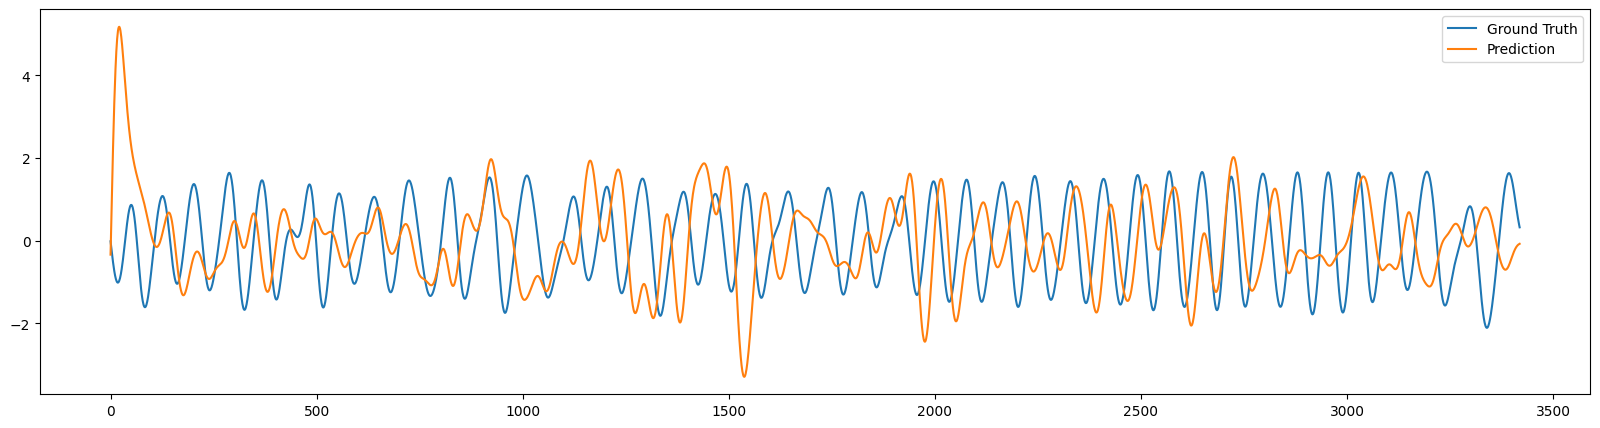

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import respiration.analysis as analysis

prediction = predictions[3]
subject = prediction['subject']
setting = prediction['setting']

gt_signal = dataset.get_breathing_signal(subject, setting)
prediction_signal = np.array(prediction['signal'])

gt_signal = torch.tensor(gt_signal, dtype=torch.float32)
gt_signal = signal_diff(gt_signal)
gt_signal = np.array(gt_signal)

compare = analysis.SignalComparator(
    prediction_signal,
    gt_signal[:len(prediction_signal)],
    30,
    detrend_tarvainen=False,
    filter_signal=True,
)

plt.figure(figsize=(20, 5))
plt.plot(compare.ground_truth, label='Ground Truth')
plt.plot(compare.prediction, label='Prediction')
plt.legend()
plt.show()

In [53]:
compare.errors()

{'pk_error': 1.0, 'cp_error': 2.0, 'nfcp_error': 4.0, 'psd_error': 13.0}